In [167]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
from datetime import datetime


def dateIndex(file):
    df = pd.read_csv(file)
    df.Date = pd.to_datetime(df.Date)
    df = df.set_index('Date')
    return df


In [168]:
garmin = dateIndex('clean_garmin_data_NEW.csv')
oura = dateIndex('clean_oura_data.csv')
whoop = dateIndex('clean_whoop_totalData.csv')

### Whoop Recovery vs Oura Readiness

Enter the time period start date (YYYY-MM-DD):  2020-05-15
Enter the time period end date (YYYY-MM-DD):  2020-06-15


Text(0, 0.5, 'Score')

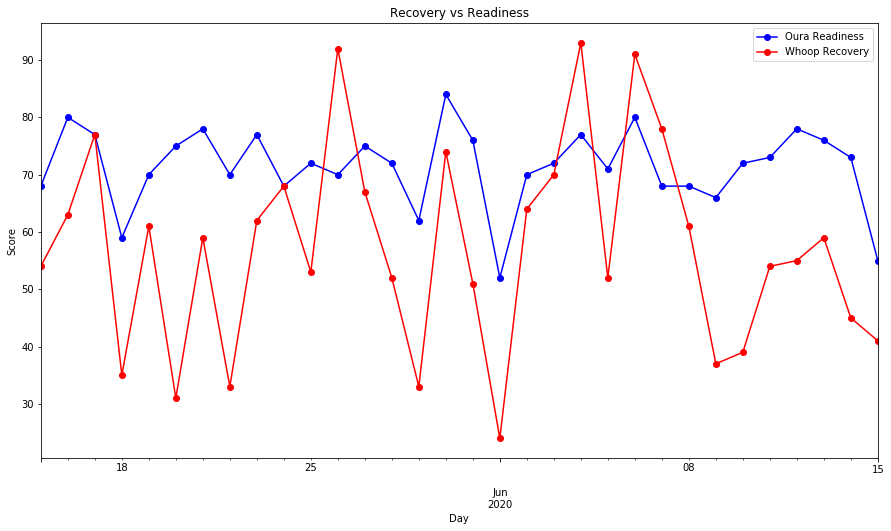

In [166]:
### This cell plots both the Oura Readiness and Whoop Recovery scores for each day.

startdate = datetime.strptime(input('Enter the time period start date (YYYY-MM-DD): '), '%Y-%m-%d')
enddate = datetime.strptime(input('Enter the time period end date (YYYY-MM-DD): '), '%Y-%m-%d')

ouraMask = (oura.index>=startdate) & (oura.index<=enddate)
whoopMask = (whoop.index>=startdate) & (whoop.index<=enddate)

owReady = oura.loc[ouraMask, 'Readiness Score']
owRecov = whoop.loc[whoopMask, 'Recovery Score']
owCombo = pd.concat([owReady, owRecov], axis=1)


# # Finds the intersection of the Oura and Whoop dataframes, combines desired scores into a new dataframe
# owCommonDates = oura.index.intersection(whoop.index)
# owReady = oura.loc[owCommonDates, 'Readiness_Score']
# owRecov = whoop.loc[owCommonDates, 'Recovery Score']
# owCombo = pd.concat([owReady, owRecov], axis=1)
owCombo = owCombo.rename(columns={'Readiness Score':'Oura Readiness', 'Recovery Score':'Whoop Recovery'})

# Plot both sets of scores
%matplotlib inline
rplot = owCombo.plot(title='Recovery vs Readiness', style=['b-o','r-o'], figsize=(15,8))
rplot.set_xlabel('Day')
rplot.set_ylabel('Score')


### Since the plot is starting to get compressed, the next thing I'd like to figure out is how to input a timeframe
### to plot that isn't so large.  Or somehow make the plot easier to look at with more data points.

### Readiness/Recovery vs Pace per Average Heart Rate

Text(0.5, 1.0, 'Average Run Pace vs Oura Readiness Score (137 BPM)')

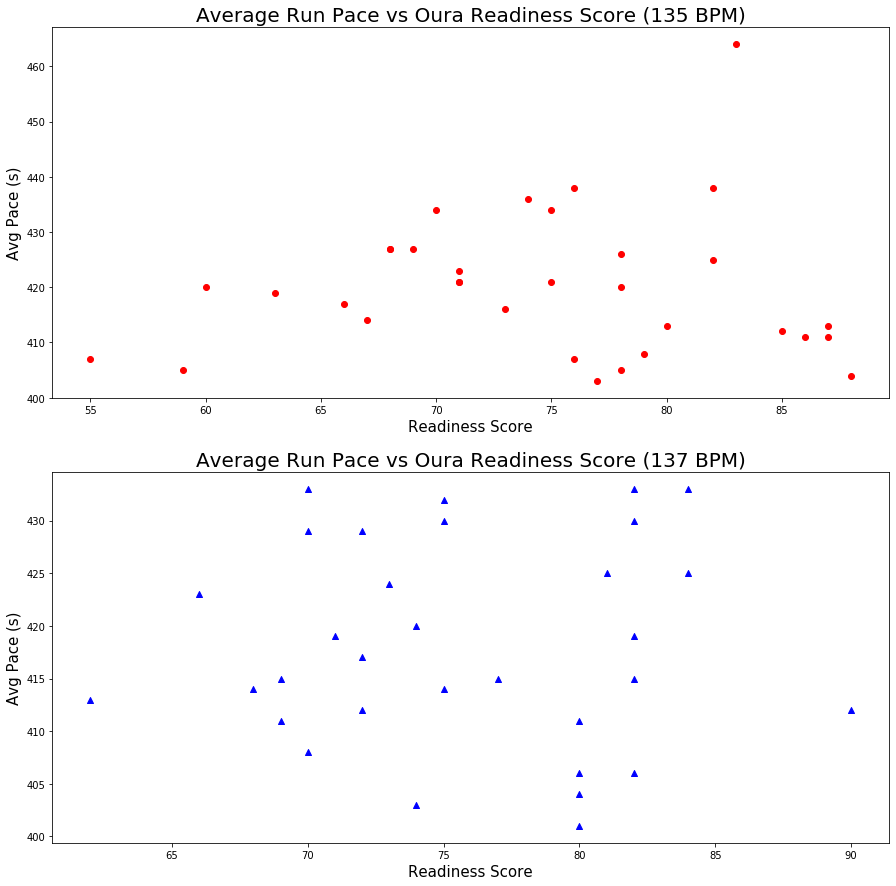

In [169]:
### This cell plots a run's average pace per mile vs that morning's Oura Readiness Score for the two most
### prevalent average heart rates from my runs.


def mmss2sec(mmss):
    """
    Function takes time in 'MM:SS' and converts it to seconds.
    INPUT: string time 'MM:SS'
    OUTPUT: integer value of total seconds
    """
    lst = mmss.split(':')
    minuteint = int(lst[0])
    secondsint = int(lst[1])
    totalsecs = minuteint*60 + secondsint
    return totalsecs


def readyVpace(gdf, odf, hrlist, indval):
    """
    Function takes in two full dataframes of Oura and Garmin data, 
    INPUT: Garmin Dataframe, Oura Dataframe, List of Heart Rate, Index Value of Heart Rates (ordered by prevalence)
    OUTPUT: numpy array of Readiness Scores and associated Avg Paces for a certain Heart Rate value
    """
    gdfHR = gdf.loc[gdf['Avg HR'] == hrlist[indval]]
    gdfPace = gdfHR['Avg Pace'].apply(mmss2sec)
    
    ogcomm = odf.index.intersection(gdf.index)
    ogready = odf.loc[ogcomm, 'Readiness Score']
    
    ogcombo = pd.concat([ogready, gdfPace], axis=1).dropna()
    readypace = np.array(ogcombo[['Readiness Score', 'Avg Pace']])
    return readypace


# Group Garmin data by the Avg Heart Rates, count the number of occurances of those heart rates,
# then sort by one of the columns.  The indexes are the Average Heart Rates.
# Most likely not the best way code this, but it works for now.  I need to understand these methods better.
groupgarmin = garmin.groupby(['Avg HR']).count().sort_values(['Activity Type'], ascending=False)
sortedHRs = groupgarmin.index


# Create numpy arrays of Readiness Scores and Avg Pace for a given heart rate.
readypace1 = readyVpace(garmin, oura, sortedHRs, 0)    # 0 is the index of the most prevalent HR
readypace2 = readyVpace(garmin, oura, sortedHRs, 1)    # 1 is the index of the second most prevalent HR


# Plotting Average Pace vs Readiness Score for two given Average Heart Rates.
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))
ax1.scatter(readypace1[:,0], readypace1[:,1], c='r', marker='o', label='{} bpm'.format(sortedHRs[0]))
ax2.scatter(readypace2[:,0], readypace2[:,1], c='b', marker='^', label='{} bpm'.format(sortedHRs[1]))


ax1.set_xlabel('Readiness Score', fontsize=15)
ax1.set_ylabel('Avg Pace (s)', fontsize=15)
ax1.set_title('Average Run Pace vs Oura Readiness Score ({} BPM)'.format(sortedHRs[0]), fontsize=20)

ax2.set_xlabel('Readiness Score', fontsize=15)
ax2.set_ylabel('Avg Pace (s)', fontsize=15)
ax2.set_title('Average Run Pace vs Oura Readiness Score ({} BPM)'.format(sortedHRs[1]), fontsize=20)




#legend = plt.legend(title='Avg HR', fontsize='small', fancybox=True)

# multiple scatter plots (for different heartrates) on one scatter plot?

# Factors that cause what I didn't expect:
# Weather, temperature
# Strain throughout the day; morning vs afternoon runs
# Elevation gain